In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

# # Create .kaggle directory and move kaggle.json
# os.makedirs("/root/.kaggle", exist_ok=True)
# !mv kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json  # Set file permissions

# # Download the dataset
# !kaggle datasets download -d zalando-research/fashionmnist

# # Extract the dataset to the current directory
# !unzip -o fashionmnist.zip -d dataset

# # Display the extracted files
# # !ls ./dataset

# # Load training and testing data
# train_data = pd.read_csv('./dataset/fashion-mnist_train.csv')
# test_data = pd.read_csv('./dataset/fashion-mnist_test.csv')

train_data = pd.read_csv('../dataset/fashion-mnist_train.csv')
test_data = pd.read_csv('../dataset/fashion-mnist_test.csv')


# Separate labels and pixel values
X_train = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0  # Normalize pixel values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0
y_test = test_data.iloc[:, 0].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the train-validation split ratio (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Use random_split to divide the dataset into train and validation sets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),      # Random rotation (up to 20 degrees)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),  # Convert to tensor
])

# Custom dataset class to apply transformations
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = image.squeeze()  # Remove unnecessary dimensions

        if self.transform:
            image = transforms.ToPILImage()(image)  # Convert to PIL image
            image = self.transform(image)  # Apply transformations

        return image, label

# Apply data augmentation to the training dataset
train_dataset = CustomDataset(train_dataset, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Print sample data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch size: {images.size()}")  # Print batch size to verify data loading
print("Data is ready")

Batch size: torch.Size([64, 1, 28, 28])
Data is ready


In [2]:
# Confirm the sizes of train, validation, and test datasets
print("Train dataset size:", len(train_loader.dataset))
print("Validation dataset size:", len(val_loader.dataset))
print("Test dataset size:", len(test_loader.dataset))


Train dataset size: 54000
Validation dataset size: 6000
Test dataset size: 10000


In [3]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In this cell, choose the model you want to train and comment out the corresponding lines for the other models (e.g., #model = CNNmodel).

In [ ]:
###Model 1 pure CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Final output (logits)
        return x
# model = CNNModel()

###Model 2 Improved CNN
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
# model = ImprovedCNNModel()


###Model 3 CNN with SE Block

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)  # Global Average Pooling
        y = F.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y  # Scale input

class CNNWithSE(nn.Module):
    def __init__(self):
        super(CNNWithSE, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.se1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.se2 = SEBlock(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.se1(self.conv1(x))))
        x = self.pool(F.relu(self.se2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNNWithSE()

###Model 4 CNN with CBAM Block

class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAMBlock, self).__init__()
        # Channel Attention
        self.channel_avg = nn.AdaptiveAvgPool2d(1)
        self.channel_max = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc2(F.relu(self.fc1(self.channel_avg(x))))
        max_out = self.fc2(F.relu(self.fc1(self.channel_max(x))))
        channel_out = self.sigmoid_channel(avg_out + max_out)

        # Apply Channel Attention
        x = x * channel_out

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))

        # Apply Spatial Attention
        x = x * spatial_out
        return x

class CNNWithCBAM(nn.Module):
    def __init__(self):
        super(CNNWithCBAM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.cbam1 = CBAMBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.cbam2 = CBAMBlock(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.cbam1(self.conv1(x))))
        x = self.pool(F.relu(self.cbam2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# model = CNNWithCBAM()

#print chose model
print(model)

CNNWithSE(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se1): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=32, out_features=2, bias=False)
    (fc2): Linear(in_features=2, out_features=32, bias=False)
    (sigmoid): Sigmoid()
  )
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se2): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=64, out_features=4, bias=False)
    (fc2): Linear(in_features=4, out_features=64, bias=False)
    (sigmoid): Sigmoid()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 0.8290, Validation Loss: 0.5635, Validation Accuracy: 79.18%
Epoch 2/100, Training Loss: 0.5779, Validation Loss: 0.4413, Validation Accuracy: 84.45%
Epoch 3/100, Training Loss: 0.4997, Validation Loss: 0.4235, Validation Accuracy: 84.15%
Epoch 4/100, Training Loss: 0.4506, Validation Loss: 0.3743, Validation Accuracy: 86.47%
Epoch 5/100, Training Loss: 0.4205, Validation Loss: 0.3540, Validation Accuracy: 87.10%
Epoch 6/100, Training Loss: 0.4004, Validation Loss: 0.3555, Validation Accuracy: 87.38%
Epoch 7/100, Training Loss: 0.3781, Validation Loss: 0.3715, Validation Accuracy: 86.18%
Epoch 8/100, Training Loss: 0.3658, Validation Loss: 0.3051, Validation Accuracy: 89.05%
Epoch 9/100, Training Loss: 0.3528, Validation Loss: 0.3253, Validation Accuracy: 87.95%
Epoch 10/100, Training Loss: 0.3424, Validation Loss: 0.3344, Validation Accuracy: 87.57%
Epoch 11/100, Training Loss: 0.3357, Validation Loss: 0.3033, Validation Accuracy: 88.98%
Epoch 12/100, Train

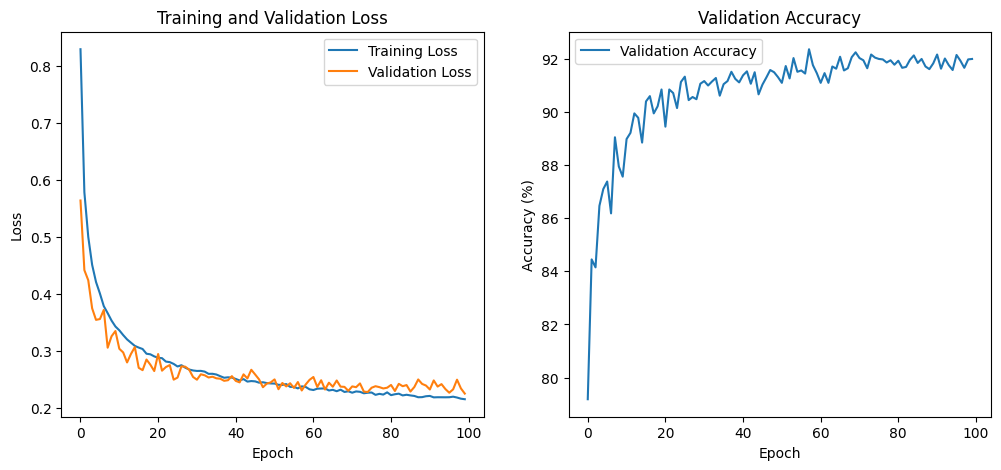

In [11]:
import matplotlib.pyplot as plt

# Move the model to GPU
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Lists to track training and validation loss
train_losses = []
val_losses = []
val_accuracies = []

# Training and Validation Loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


ImprovedCNN model evaluation (run this one when using ImprovedCNN model)

In [9]:
# Set the ImprovedCNNmodel to evaluation mode
model.eval()
correct, total = 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {test_accuracy:.2f}%')

Accuracy on the test dataset: 92.50%


CNNwithSE model evaluation (run this one when using CNNwithSE model)

In [12]:
# Set the CNNwithSE model to evaluation mode
model.eval()
correct, total = 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {test_accuracy:.2f}%')

Accuracy on the test dataset: 93.08%


CNN model evaluation (run this one when using CNN model)

In [6]:
# Set the CNNmodel to evaluation mode
model.eval()
correct, total = 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {test_accuracy:.2f}%')



Accuracy on the test dataset: 92.66%


CNNwithCBAM model evaluation (run this one when using CNNwithCBAM model)

In [21]:
# Set the CNNwithCBAM model to evaluation mode
model.eval()
correct, total = 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {test_accuracy:.2f}%')

Accuracy on the test dataset: 92.75%


Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1000
     Trouser       0.99      1.00      0.99      1000
    Pullover       0.90      0.90      0.90      1000
       Dress       0.93      0.94      0.93      1000
        Coat       0.88      0.90      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.77      0.79      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      1.00      0.99      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



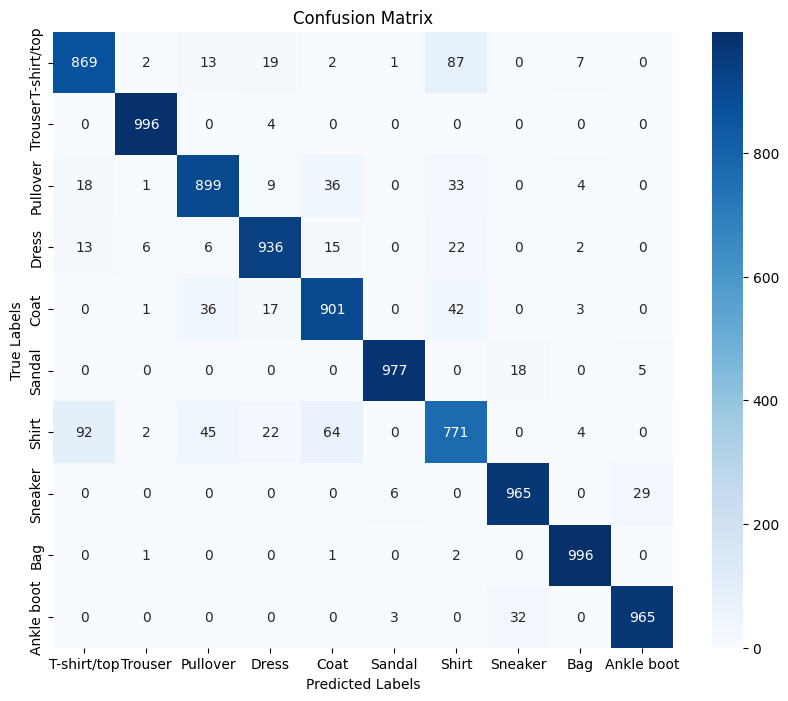

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
], yticklabels=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()